# Mod 3 Final Project

## Student Info

- Name: Alex Beat
- Cohort: 100719 pt 
- Instructor: James Irving


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and at the bottom of the `MOD_PROJECT_README.ipynb`
- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# PROJECT

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

import pandas as pd


fsds_1007219  v0.7.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [2]:

import scipy.stats as stats
import numpy as np

def Cohen_d(group1, group2, correction = False):
    """Compute Cohen's d
    d = (group1.mean()-group2.mean())/pool_variance.
    pooled_variance= (n1 * var1 + n2 * var2) / (n1 + n2)

    Args:
        group1 (Series or NumPy array): group 1 for calculating d
        group2 (Series or NumPy array): group 2 for calculating d
        correction (bool): Apply equation correction if N<50. Default is False. 
            - Url with small ncorrection equation: 
                - https://www.statisticshowto.datasciencecentral.com/cohens-d/ 
    Returns:
        d (float): calculated d value
         
    INTERPRETATION OF COHEN's D: 
    > Small effect = 0.2
    > Medium Effect = 0.5
    > Large Effect = 0.8
    
    """
    import scipy.stats as stats
    import scipy   
    import numpy as np
    N = len(group1)+len(group2)
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    ## Apply correction if needed
    if (N < 50) & (correction==True):
        d=d * ((N-3)/(N-2.25))*np.sqrt((N-2)/N)
    return d


#Your code here
def find_outliers_Z(data):
    """Use scipy to calculate absolute Z-scores 
    and return boolean series where True indicates it is an outlier.

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    """
    import pandas as pd
    import numpy as np
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    ## Calculate z-scores
    zs = stats.zscore(data)
    
    ## Find z-scores >3 awayfrom mean
    idx_outs = np.abs(zs)>3
    
    ## If input was a series, make idx_outs index match
    if isinstance(data,pd.Series):
        return pd.Series(idx_outs,index=data.index)
    else:
        return pd.Series(idx_outs)
    
    
    
def find_outliers_IQR(data):
    """Use Tukey's Method of outlier removal AKA InterQuartile-Range Rule
    and return boolean series where True indicates it is an outlier.
    - Calculates the range between the 75% and 25% quartiles
    - Outliers fall outside upper and lower limits, using a treshold of  1.5*IQR the 75% and 25% quartiles.

    IQR Range Calculation:    
        res = df.describe()
        IQR = res['75%'] -  res['25%']
        lower_limit = res['25%'] - 1.5*IQR
        upper_limit = res['75%'] + 1.5*IQR

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    
    """
    df_b=data
    res= df_b.describe()

    IQR = res['75%'] -  res['25%']
    lower_limit = res['25%'] - 1.5*IQR
    upper_limit = res['75%'] + 1.5*IQR

    idx_outs = (df_b>upper_limit) | (df_b<lower_limit)

    return idx_outs


def prep_data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    import pandas as pd
    df_tukey = pd.DataFrame(columns=['data','group'])

    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey,grp_df],axis=0)
    return df_tukey

In [3]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [4]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# Hypothesis 1

## Question

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

## Null and Alternative Hypothesis

- $H_0$: Customers bought the same quantity of both discounted and non-discounted products. 

- $H_1$: Customers bought the same quantity of both discounted and non-discounted products.

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Two different groups if comparing discount or full price.
        - So we use 2 sample t-test

### split data into 2 groups

In [5]:
cur.execute("""SELECT * from OrderDetail""")
col_names=[x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [6]:
h1df = pd.DataFrame(cur.fetchall(), columns=col_names)
h1df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [7]:
## Create 'discounted' column for groupby 
h1df['discounted'] = h1df['Discount']>0
h1df['discounted'] = h1df['discounted'].map({True:'Discounted',False:'Full Price'})
h1df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.00,12,0.00,Full Price
1,10248/42,10248,42,9.80,10,0.00,Full Price
2,10248/72,10248,72,34.80,5,0.00,Full Price
3,10249/14,10249,14,18.60,9,0.00,Full Price
4,10249/51,10249,51,42.40,40,0.00,Full Price
...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted
2151,11077/66,11077,66,17.00,1,0.00,Full Price
2152,11077/73,11077,73,15.00,2,0.01,Discounted
2153,11077/75,11077,75,7.75,4,0.00,Full Price


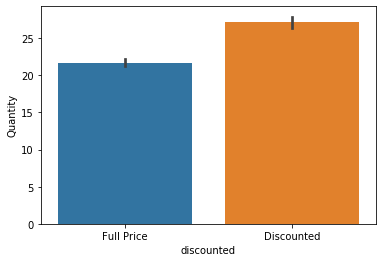

In [8]:
sns.barplot(data=h1df, x='discounted',y='Quantity',ci=68,)

### put data into dict

In [9]:
h1dict = {}
for name in h1df['discounted'].unique():
    h1dict[name] = h1df.groupby('discounted').get_group(name)['Quantity']
    
h1dict

{'Full Price': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2147     2
 2148     2
 2151     1
 2153     4
 2154     2
 Name: Quantity, Length: 1317, dtype: int64, 'Discounted': 6       35
 7       15
 8        6
 9       15
 11      40
         ..
 2144     2
 2146     3
 2149     2
 2150     2
 2152     2
 Name: Quantity, Length: 838, dtype: int64}

## STEP 2: Do we meet the assumptions of the chosen test?

Independent t-test (2-sample)

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Quantity for Full Price vs Discounted Products')]

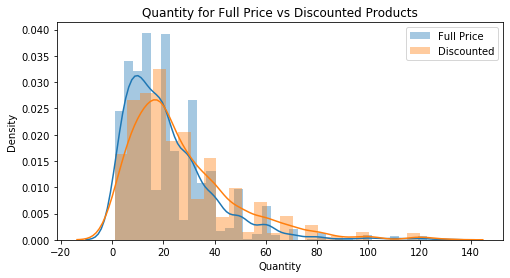

In [10]:
##Outlier Removal
fig,ax=plt.subplots(figsize=(8,4))
for name,values in h1dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Quantity for Full Price vs Discounted Products', ylabel='Density')

In [11]:
for name,values in h1dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h1dict[name] = values[~idx_outs]
    

Found 20 outliers using Z-score method for Full Price.
Found 15 outliers using Z-score method for Discounted.


### Check result of outlier removal on plot

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Quantity for Full Price vs Discounted Products')]

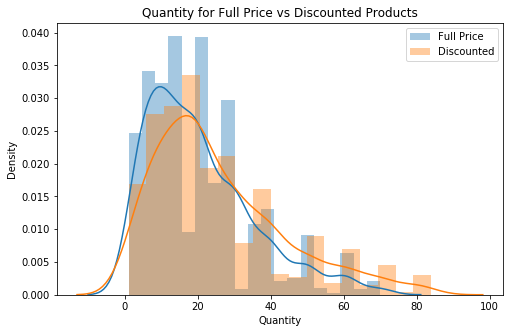

In [59]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h1dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Quantity for Full Price vs Discounted Products', ylabel='Density')

### 1. Test Assumption of Normality

In [12]:
import scipy.stats as stats

In [13]:
for key,values in h1dict.items():
    stat,p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Full Price Normaltest p-value=0.0
	-The data is NOT normal.
Group Discounted Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

In [14]:
len(h1dict['Full Price']), len(h1dict['Discounted'])

(1297, 823)

But group sizes (n) are bigger than required 15 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [15]:
h1data = []
for key,vals in h1dict.items():
    h1data.append(vals)

In [16]:
h1data[0]

0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

In [17]:
stats.levene(h1data[0],h1data[1])

LeveneResult(statistic=19.187113832590878, pvalue=1.2429073348187694e-05)

In [18]:
stat,p = stats.levene(*h1data)
print(f"Levene's Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Use a Welch's T-Test. 
 - for scipy, add equal_var=False to ttest_ind

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [19]:
stat,h1p = stats.ttest_ind(h1dict['Full Price'], h1dict['Discounted'], equal_var=False)
print(f"Welch's t-test p value={round(h1p,4)}")

sig = 'is rejected' if h1p<.05 else 'is accepted'

print(f"\t- Null Hypothesis {sig}.")

Welch's t-test p value=0.0
	- Null Hypothesis is rejected.


### Calculate effect size (e.g. Cohen's  𝑑 )

In [20]:
h1effectsize = Cohen_d(h1dict['Full Price'],h1dict['Discounted'])
h1effectsize

-0.32001140965727837

# --Question

0.3 effect size is small. What does this tell us?

### Report statistical power (optional)

statsmodels.stats.power:
TTestIndPower , TTestPower

In [21]:
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

In [22]:
len(h1dict['Full Price']+h1dict['Discounted'])

2120

In [23]:
# show the power to see how well we can reject null.
power_analysis.solve_power(effect_size=h1effectsize, nobs1=2120, alpha=h1p)

0.9998181894007312

In [24]:
# power is .99 so yeah we have a solid bet of rejecting null hypothesis and not getting any type 1 errors.

## What levels of discount?

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

### Make dict into dataframes for tukeys

In [25]:
h1dict['Full Price']

0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

In [26]:
def prepare_for_tukeys(group):
    df_tukey= pd.DataFrame()
    for k,v in group.items():
        df_grp = pd.DataFrame(v)
        df_grp['Group']=k
        df_tukey = pd.concat([df_tukey,df_grp],axis=0)

    return df_tukey

In [27]:
# df_tukey = prepare_for_tukeys(h1dict)
# df_tukey

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [29]:
# tukeys = pairwise_tukeyhsd(df_tukey['Quantity'],df_tukey['Group'])
# tukeys.summary()

# Hypothesis 2

## Question

> Does discount amount have a statistically significant effect on the total spent ($) on a product in an order? If so, at what level(s) of discount?

## Null and Alternative Hypothesis

- $H_0$: Customers spend the same total amounts on both discounted and non-discounted products. 

- $H_1$: Customers spend different total amounts of money on discounted products vs full price products. 

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Two different groups if comparing discount or full price.
        - So we use 2 sample t-test

### split data into 2 groups

In [30]:
cur.execute("""SELECT Id, UnitPrice, Quantity, Discount from OrderDetail""")
col_names=[x[0] for x in cur.description]
col_names

['Id', 'UnitPrice', 'Quantity', 'Discount']

In [31]:
h2df = pd.DataFrame(cur.fetchall(), columns=col_names)
h2df

,Id,UnitPrice,Quantity,Discount
0,10248/11,14.00,12,0.00
1,10248/42,9.80,10,0.00
2,10248/72,34.80,5,0.00
3,10249/14,18.60,9,0.00
4,10249/51,42.40,40,0.00
...,...,...,...,...
2150,11077/64,33.25,2,0.03
2151,11077/66,17.00,1,0.00
2152,11077/73,15.00,2,0.01
2153,11077/75,7.75,4,0.00


In [32]:
## Create 'discounted' column for groupby 
h2df['discounted'] = h2df['Discount']>0
h2df['discounted'] = h2df['discounted'].map({True:'Discounted',False:'Full Price'})
h2df

,Id,UnitPrice,Quantity,Discount,discounted
0,10248/11,14.00,12,0.00,Full Price
1,10248/42,9.80,10,0.00,Full Price
2,10248/72,34.80,5,0.00,Full Price
3,10249/14,18.60,9,0.00,Full Price
4,10249/51,42.40,40,0.00,Full Price
...,...,...,...,...,...
2150,11077/64,33.25,2,0.03,Discounted
2151,11077/66,17.00,1,0.00,Full Price
2152,11077/73,15.00,2,0.01,Discounted
2153,11077/75,7.75,4,0.00,Full Price


In [33]:
## create total spent
h2df["Total Spent"] = h2df['UnitPrice'] * h2df['Quantity']
h2df

,Id,UnitPrice,Quantity,Discount,discounted,Total Spent
0,10248/11,14.00,12,0.00,Full Price,168.0
1,10248/42,9.80,10,0.00,Full Price,98.0
2,10248/72,34.80,5,0.00,Full Price,174.0
3,10249/14,18.60,9,0.00,Full Price,167.4
4,10249/51,42.40,40,0.00,Full Price,1696.0
...,...,...,...,...,...,...
2150,11077/64,33.25,2,0.03,Discounted,66.5
2151,11077/66,17.00,1,0.00,Full Price,17.0
2152,11077/73,15.00,2,0.01,Discounted,30.0
2153,11077/75,7.75,4,0.00,Full Price,31.0


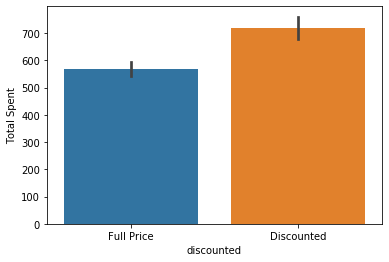

In [34]:
sns.barplot(data=h2df, x='discounted', y='Total Spent', ci=68 )

### put data into dict

In [35]:
h2dict = {}
for name in h2df['discounted'].unique():
    h2dict[name] = h2df.groupby('discounted').get_group(name)['Total Spent']
    
h2dict

{'Full Price': 0        168.0
 1         98.0
 2        174.0
 3        167.4
 4       1696.0
          ...  
 2147      14.0
 2148      48.0
 2151      17.0
 2153      31.0
 2154      26.0
 Name: Total Spent, Length: 1317, dtype: float64, 'Discounted': 6       1484.0
 7        252.0
 8        100.8
 9        234.0
 11      2592.0
          ...  
 2144      36.0
 2146      36.0
 2149      68.0
 2150      66.5
 2152      30.0
 Name: Total Spent, Length: 838, dtype: float64}

## STEP 2: Do we meet the assumptions of the chosen test?

Independent t-test (2-sample)

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Spent on Full Price vs Discounted Products')]

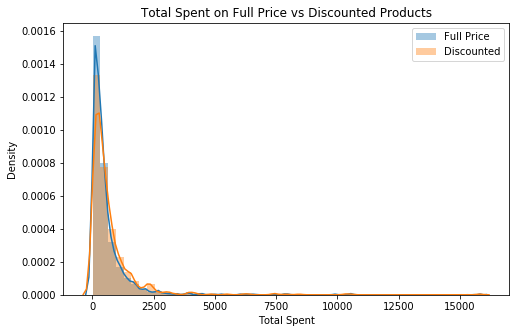

In [36]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h2dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent on Full Price vs Discounted Products', ylabel='Density')

In [37]:
for name,values in h2dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h2dict[name] = values[~idx_outs]
    

Found 19 outliers using Z-score method for Full Price.
Found 13 outliers using Z-score method for Discounted.


### Check result of outlier removal on plot

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Spent on Full Price vs Discounted Products')]

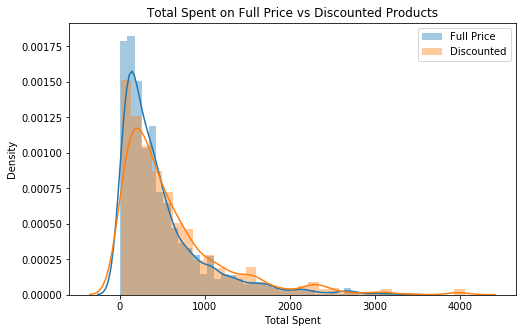

In [58]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h2dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent on Full Price vs Discounted Products', ylabel='Density')

### 1. Test Assumption of Normality

In [38]:
import scipy.stats as stats

In [39]:
for key,values in h2dict.items():
    stat,p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Full Price Normaltest p-value=0.0
	-The data is NOT normal.
Group Discounted Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

In [40]:
len(h2dict['Full Price']), len(h2dict['Discounted'])

(1298, 825)

But group sizes (n) are bigger than required 15 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [41]:
# put data into lists for levene's test args
h2data = []
for key,vals in h2dict.items():
    h2data.append(vals)

In [42]:
h2data[1]

6       1484.0
7        252.0
8        100.8
9        234.0
11      2592.0
         ...  
2144      36.0
2146      36.0
2149      68.0
2150      66.5
2152      30.0
Name: Total Spent, Length: 825, dtype: float64

In [43]:
stats.levene(h2data[0],h2data[1])

LeveneResult(statistic=16.674064580142414, pvalue=4.603065710436535e-05)

In [44]:
stat,p = stats.levene(*h2data)
print(f"Levene's Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Use a Welch's T-Test. 
 - for scipy, add equal_var=False to ttest_ind

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [45]:
stat,h2p = stats.ttest_ind(h2dict['Full Price'], h2dict['Discounted'], equal_var=False)
print(f"Welch's t-test p value={round(h2p,4)}")

sig = 'is rejected' if h2p<.05 else 'is accepted'

print(f"\t- Null Hypothesis {sig}.")

Welch's t-test p value=0.0
	- Null Hypothesis is rejected.


### Calculate effect size (e.g. Cohen's  𝑑 )

In [46]:
h2effectsize = Cohen_d(h2dict['Full Price'],h2dict['Discounted'])
h2effectsize

-0.22821293413002144

# --Question

0.2 effect size is small. What does this tell us?

### Report statistical power (optional)

statsmodels.stats.power:
TTestIndPower , TTestPower

In [47]:
len(h2dict['Full Price']+h2dict['Discounted'])

2123

In [48]:
# show the power to see how well we can reject null.
power_analysis.solve_power(effect_size=h2effectsize, nobs1=2123, alpha=h2p)

0.9946532659778071

In [49]:
# power is .99 so yeah we have a solid bet of rejecting null hypothesis and not getting any type 1 errors.

## What levels of discount?

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

### Make dict into dataframes for tukeys

In [50]:
h2dict['Full Price']

0        168.0
1         98.0
2        174.0
3        167.4
4       1696.0
         ...  
2147      14.0
2148      48.0
2151      17.0
2153      31.0
2154      26.0
Name: Total Spent, Length: 1298, dtype: float64

In [51]:
h2df_tukey = prepare_for_tukeys(h2dict)
h2df_tukey

,Total Spent,Group
0,168.0,Full Price
1,98.0,Full Price
2,174.0,Full Price
3,167.4,Full Price
4,1696.0,Full Price
...,...,...
2144,36.0,Discounted
2146,36.0,Discounted
2149,68.0,Discounted
2150,66.5,Discounted


In [52]:
h2tukeys = pairwise_tukeyhsd(h2df_tukey['Total Spent'],h2df_tukey['Group'])
h2tukeys.summary()

TypeError: zip argument #4 must support iteration

# Hypothesis 3

## Question

> Does supplier region have a statistically significant effect on the quantity of a product in an order?

## Null and Alternative Hypothesis

- $H_0$: Unit price does not have a significant effect on the quantity of a product bought. 

- $H_1$: Unit price does have a significant effect on the quantity of a product bought.

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Testing the effect of a treatment on a sample so we use 2 sample t-test

### Put data in df

In [102]:
cur.execute("""SELECT od.OrderID, od.ProductID, od.UnitPrice, od.Quantity, o.EmployeeID
                FROM OrderDetail od
                JOIN Order o ON od.OrderID = o.OrderID
            """)
col_names=[x[0] for x in cur.description]
col_names

OperationalError: near "Order": syntax error

In [ ]:
c.execute("""SELECT c.customerName, c.customerNumber, p.productName,
                    p.productCode, sum(od.quantityOrdered) as TotalOrdered
                    FROM Customers c JOIN Orders o 
                                     ON c.customerNumber = o.customerNumber
                                     JOIN OrderDetails od
                                     ON od.orderNumber = o.orderNumber
                                     JOIN Products p
                                     USING(productCode)
             GROUP BY c.customerNumber, productCode
             HAVING SUM(od.quantityOrdered) >= 10 
             ORDER BY TotalOrdered DESC;"""

In [69]:
h3df = pd.DataFrame(cur.fetchall(), columns=col_names)
h3df

,Id,CompanyName,City,Region,Country
0,1,Exotic Liquids,London,British Isles,UK
1,2,New Orleans Cajun Delights,New Orleans,North America,USA
2,3,Grandma Kelly's Homestead,Ann Arbor,North America,USA
3,4,Tokyo Traders,Tokyo,Eastern Asia,Japan
4,5,Cooperativa de Quesos 'Las Cabras',Oviedo,Southern Europe,Spain
5,6,Mayumi's,Osaka,Eastern Asia,Japan
6,7,"Pavlova, Ltd.",Melbourne,Victoria,Australia
7,8,"Specialty Biscuits, Ltd.",Manchester,British Isles,UK
8,9,PB Knäckebröd AB,Göteborg,Northern Europe,Sweden
9,10,Refrescos Americanas LTDA,Sao Paulo,South America,Brazil


In [73]:
h3df['Region'].unique()

array(['British Isles', 'North America', 'Eastern Asia',
       'Southern Europe', 'Victoria', 'Northern Europe', 'South America',
       'Western Europe', 'Scandinavia', 'South-East Asia', 'NSW'],
      dtype=object)

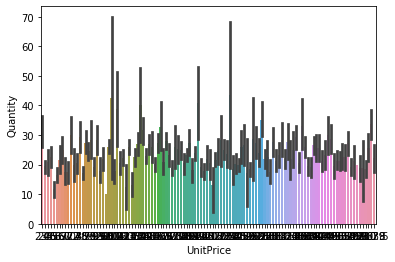

In [60]:
sns.barplot(data=h3df, x='UnitPrice', y='Quantity', ci=68 )

### put data into dict

In [35]:
h2dict = {}
for name in h2df['discounted'].unique():
    h2dict[name] = h2df.groupby('discounted').get_group(name)['Total Spent']
    
h2dict

{'Full Price': 0        168.0
 1         98.0
 2        174.0
 3        167.4
 4       1696.0
          ...  
 2147      14.0
 2148      48.0
 2151      17.0
 2153      31.0
 2154      26.0
 Name: Total Spent, Length: 1317, dtype: float64, 'Discounted': 6       1484.0
 7        252.0
 8        100.8
 9        234.0
 11      2592.0
          ...  
 2144      36.0
 2146      36.0
 2149      68.0
 2150      66.5
 2152      30.0
 Name: Total Spent, Length: 838, dtype: float64}

## STEP 2: Do we meet the assumptions of the chosen test?

Independent t-test (2-sample)

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Spent on Full Price vs Discounted Products')]

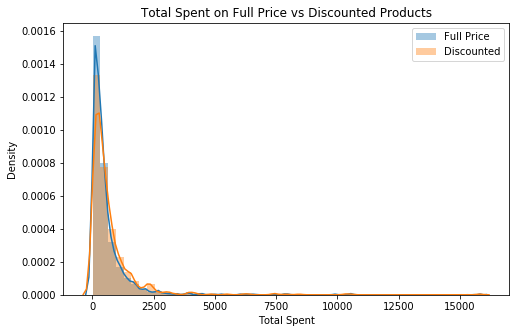

In [36]:
fig,ax=plt.subplots(figsize=(8,5))
for name,values in h2dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Spent on Full Price vs Discounted Products', ylabel='Density')

In [37]:
for name,values in h2dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h2dict[name] = values[~idx_outs]
    

Found 19 outliers using Z-score method for Full Price.
Found 13 outliers using Z-score method for Discounted.


### 1. Test Assumption of Normality

In [38]:
import scipy.stats as stats

In [39]:
for key,values in h2dict.items():
    stat,p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Full Price Normaltest p-value=0.0
	-The data is NOT normal.
Group Discounted Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

In [40]:
len(h2dict['Full Price']), len(h2dict['Discounted'])

(1298, 825)

But group sizes (n) are bigger than required 15 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

### 2. Test for Equal Variance

In [41]:
# put data into lists for levene's test args
h2data = []
for key,vals in h2dict.items():
    h2data.append(vals)

In [42]:
h2data[1]

6       1484.0
7        252.0
8        100.8
9        234.0
11      2592.0
         ...  
2144      36.0
2146      36.0
2149      68.0
2150      66.5
2152      30.0
Name: Total Spent, Length: 825, dtype: float64

In [43]:
stats.levene(h2data[0],h2data[1])

LeveneResult(statistic=16.674064580142414, pvalue=4.603065710436535e-05)

In [44]:
stat,p = stats.levene(*h2data)
print(f"Levene's Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Use a Welch's T-Test. 
 - for scipy, add equal_var=False to ttest_ind

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [45]:
stat,h2p = stats.ttest_ind(h2dict['Full Price'], h2dict['Discounted'], equal_var=False)
print(f"Welch's t-test p value={round(h2p,4)}")

sig = 'is rejected' if h2p<.05 else 'is accepted'

print(f"\t- Null Hypothesis {sig}.")

Welch's t-test p value=0.0
	- Null Hypothesis is rejected.


### Calculate effect size (e.g. Cohen's  𝑑 )

In [46]:
h2effectsize = Cohen_d(h2dict['Full Price'],h2dict['Discounted'])
h2effectsize

-0.22821293413002144

# --Question

0.2 effect size is small. What does this tell us?

### Report statistical power (optional)

statsmodels.stats.power:
TTestIndPower , TTestPower

In [47]:
len(h2dict['Full Price']+h2dict['Discounted'])

2123

In [48]:
# show the power to see how well we can reject null.
power_analysis.solve_power(effect_size=h2effectsize, nobs1=2123, alpha=h2p)

0.9946532659778071

In [49]:
# power is .99 so yeah we have a solid bet of rejecting null hypothesis and not getting any type 1 errors.

## What levels of discount?

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

### Make dict into dataframes for tukeys

In [50]:
h2dict['Full Price']

0        168.0
1         98.0
2        174.0
3        167.4
4       1696.0
         ...  
2147      14.0
2148      48.0
2151      17.0
2153      31.0
2154      26.0
Name: Total Spent, Length: 1298, dtype: float64

In [51]:
h2df_tukey = prepare_for_tukeys(h2dict)
h2df_tukey

,Total Spent,Group
0,168.0,Full Price
1,98.0,Full Price
2,174.0,Full Price
3,167.4,Full Price
4,1696.0,Full Price
...,...,...
2144,36.0,Discounted
2146,36.0,Discounted
2149,68.0,Discounted
2150,66.5,Discounted


In [52]:
h2tukeys = pairwise_tukeyhsd(h2df_tukey['Total Spent'],h2df_tukey['Group'])
h2tukeys.summary()

TypeError: zip argument #4 must support iteration